In [22]:
# Standard Python modules
import os, sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re
import seaborn as sns
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import geopandas
import shapely.geometry

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial
from plotter import draw_basemap, plot_terrain


pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
path_to_data = '/data/projects/Comet/cwp140/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [4]:
## load watershed trajectory
fname = '/home/dnash/comet_data/preprocessed/ERA5_trajectories/PRISM_HUC8_14080107.nc'
ERA5 = xr.open_dataset(fname)
## start with one trajectory, then loop all
# ERA5 = ERA5.isel(start_date=10)
ERA5

<xarray.Dataset>
Dimensions:       (index: 72, start_date: 87)
Coordinates:
  * index         (index) int64 0 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70 71
  * start_date    (start_date) datetime64[ns] 2000-10-24 ... 2019-05-21
Data variables:
    time          (start_date, index) datetime64[ns] ...
    latitude      (start_date, index) float64 ...
    longitude     (start_date, index) float64 ...
    level         (start_date, index) float64 ...
    q             (start_date, index) float64 ...
    u             (start_date, index) float64 ...
    v             (start_date, index) float64 ...
    w             (start_date, index) float64 ...
    dq            (start_date, index) float64 ...
    drying_ratio  (start_date, index) float64 ...

In [28]:
df = ERA5.to_dataframe()

gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf

# heatmap, xedges, yedges = np.histogram2d(lons.longitude.values, lats.latitude.values, bins=50)
# heatmap.T

time  latitude  longitude  level    q     u  \
index start_date                                                              
0     2000-10-24 2000-10-24 12:00:00     37.18    -108.53 700.00 4.08 -2.95   
      2001-08-14 2001-08-14 12:00:00     37.18    -108.53 700.00 7.83  6.49   
      2002-09-08 2002-09-08 12:00:00     37.18    -108.53 700.00 6.06  0.03   
      2002-09-11 2002-09-11 12:00:00     37.18    -108.53 700.00 6.79  0.88   
      2002-11-09 2002-11-09 12:00:00     37.18    -108.53 700.00 5.50 23.84   
...                              ...       ...        ...    ...  ...   ...   
71    2019-02-22 2019-02-19 13:00:00     37.87    -118.93 587.99 0.10 -0.45   
      2019-03-12 2019-03-09 13:00:00     17.42    -116.55 767.50 5.38 -1.51   
      2019-03-13 2019-03-10 13:00:00     37.58    -110.51 866.52 2.95 -0.00   
      2019-04-30 2019-04-27 13:00:00     31.69    -120.20 852.34 3.35  5.48   
      2019-05-21 2019-05-18 13:00:00     30.92    -126.25 870.61 4.78  6.52   

                      v     w    dq  drying_ratio                     geometry  
index start_date                                                                
0     2000-10-24   7.18 -0.35   NaN           NaN  POINT (-108.52883 37.17831)  
      2001-08-14   1.49 -0.19   NaN           NaN  POINT (-108.52883 37.17831)  
      2002-09-08   3.34  0.44   NaN           NaN  POINT (-108.52883 37.17831)  
      2002-09-11   7.42  0.14   NaN           NaN  POINT (-108.52883 37.17831)  
      2002-11-09   1.56 -1.44   NaN           NaN  POINT (-108.52883 37.17831)  
...                 ...   ...   ...           ...                          ...  
71    2019-02-22 -21.82 -0.23 -0.03        -32.81  POINT (-118.93307 37.87197)  
      2019-03-12   4.88  0.07  0.06          1.21  POINT (-116.54586 17.42396)  
      2019-03-13  -0.50  0.14 -0.13         -4.58  POINT (-110.51327 37.58459)  
      2019-04-30  -2.58  0.07 -0.07         -2.21  POINT (-120.19993 31.69302)  
      2019-05-21  -0.37 -0.10  0.07          1.55  POINT (-126.24872 30.91510)  

[6264 rows x 11 columns]

In [52]:
### Code is based on https://james-brennan.github.io/posts/fast_gridding_geopandas/

### BUILD A GRID 
# total area for the grid
xmin, ymin, xmax, ymax= gdf.total_bounds
# how many cells across and down
n_cells=50
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "EPSG:4326"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = geopandas.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

merged = geopandas.sjoin(gdf, cell, how='left', predicate='within')

# make a simple count variable that we can sum
merged['n_traj']=1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="count")
# put this into cell
cell.loc[dissolve.index, 'n_traj'] = dissolve.n_traj.values

(-149.630443762969, -93.93035942697058, 11.901420406240833, 53.118363410988316)

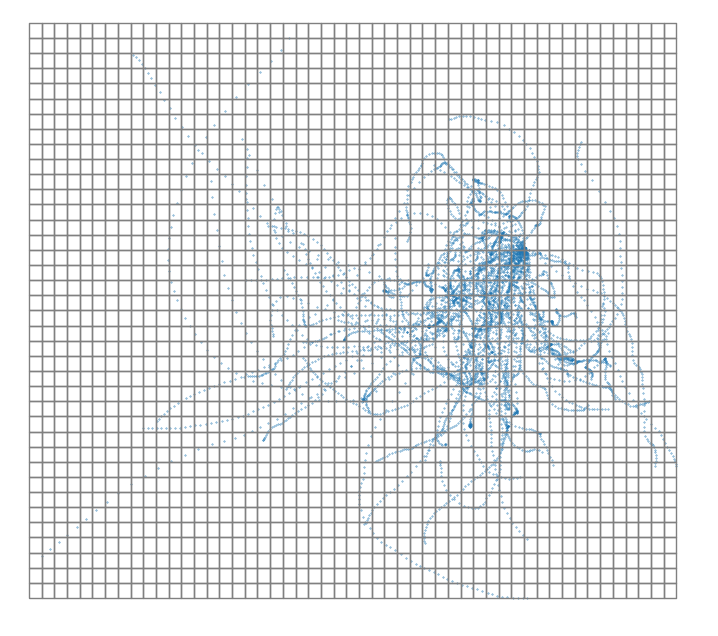

In [53]:
# ## plot the grid over the point data
# ax = gdf.plot(markersize=.1, figsize=(12, 8))
# plt.autoscale(False)
# cell.plot(ax=ax, facecolor="none", edgecolor='grey')
# ax.axis("off")

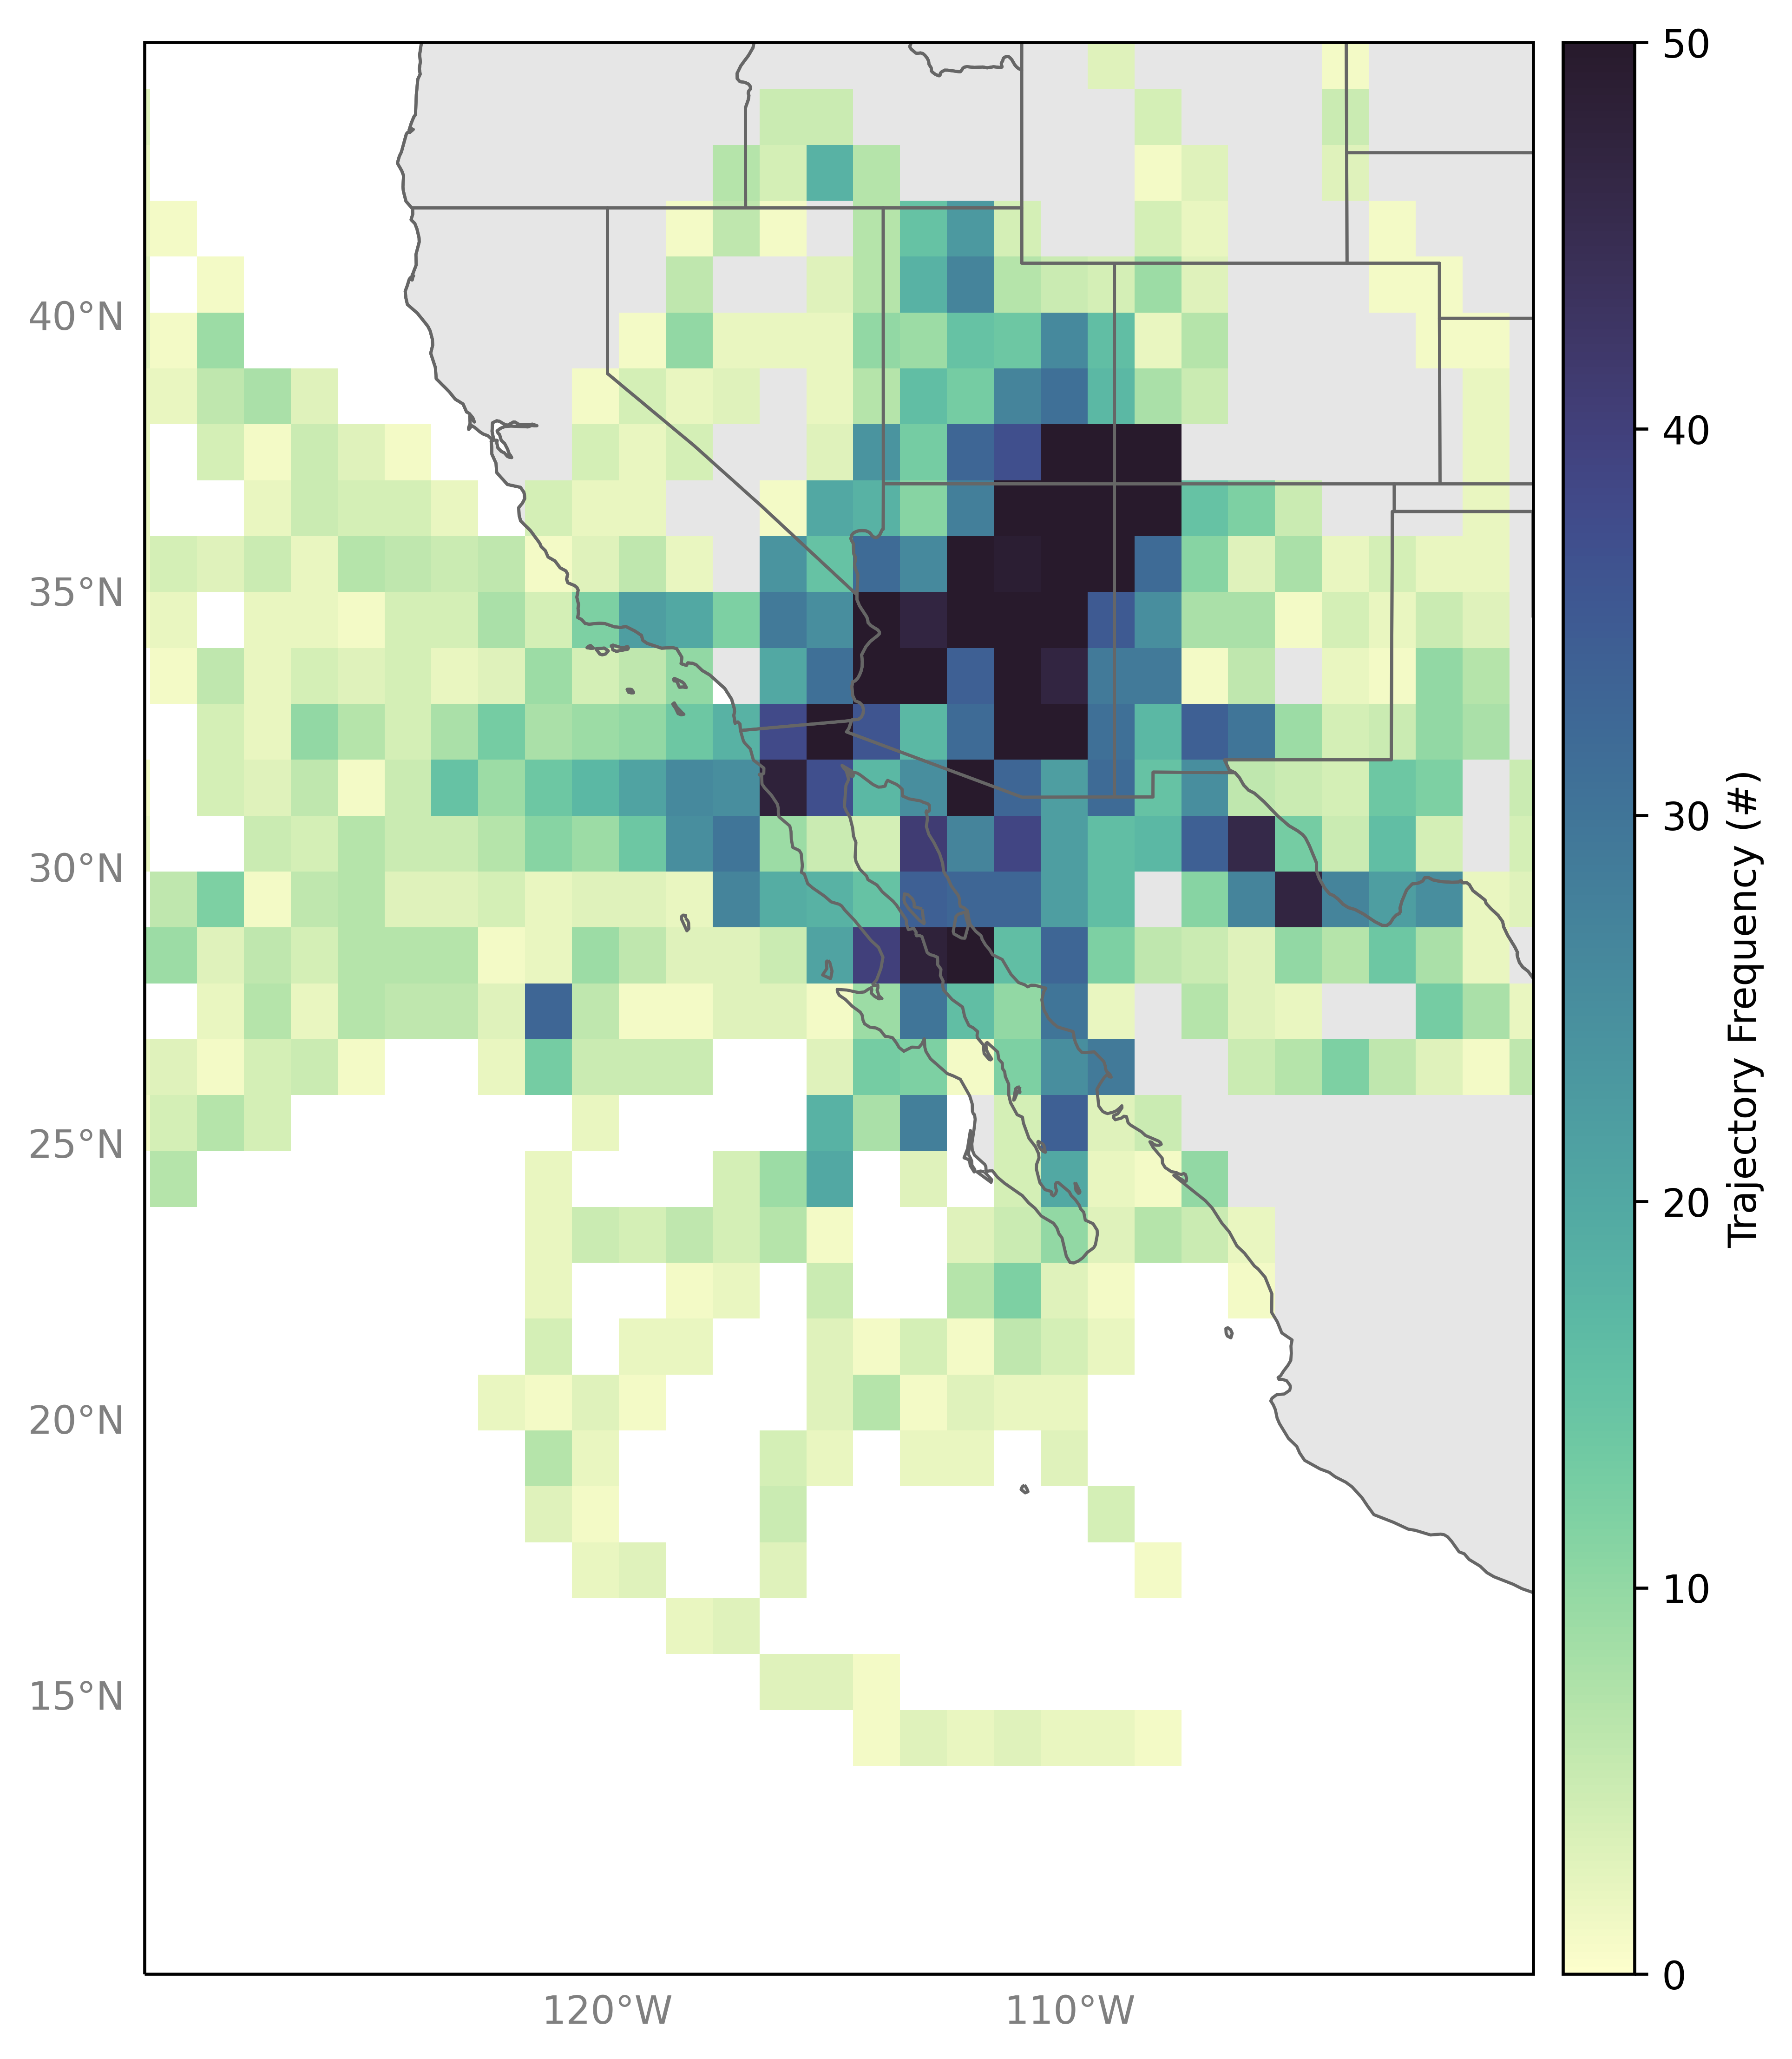

In [74]:
ext = [-130., -100., 10., 45.] 
fmt = 'png'

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

nrows = 1
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1, 0.05], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(7.0 ,9.0))
fig.dpi = 600
fname = path_to_figs + 'test_trajectory'

ax = fig.add_subplot(gs[0,0], projection=mapcrs)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=True, right_lats=False)
ax.set_extent(ext, datacrs)

ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
# Add color bar axis
cbax = plt.subplot(gs[0,1]) # colorbar axis
## plotting based off of https://geopandas.org/en/stable/docs/user_guide/mapping.html
cf = cell.plot(ax=ax, column='n_traj', cmap=cmo.deep, vmin=0, vmax=50, edgecolor=None, legend=True, cax=cbax,
              legend_kwds={"label": "Trajectory Frequency (#)", "orientation": "vertical"})
# cf = ax.add_geometries(cell['geometry'], crs=ccrs.epsg('4326'), cmap=cmo.deep, vmax=50, edgecolor=None)


# cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
# cb.set_label('Trajectory Frequency (#)', fontsize=11)
# cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()